In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image, set_spines_visible
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## two types of recordings 
1) 2024_0403_115306_025.MP4 - 60Hz?, 2:23 long, several captures, 80% prob. of ventral view
2) 2024_0403_115801_028.MP4 - 120Hz, two or three captures at second 2 and 9

frames to annotaed:
1) 140-235 (157: contact, 158: schaufel), 
2) 1025-1130 (1045: contact, 1050-1052: schaufeln, cilien)

## 2024_0403_115801_028.MP4 - 120Hz, two or three captures at second 2 and 9

In [2]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0403_115801_028.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

pixel_per_real_width = .83
mpp = 1.2  # microns_per_pixel
print("D high - HD, pixel_per_real_width = ", pixel_per_real_width, "fps: ", fps)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(1040, 1140, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None


(120, 1588, 1280, 720)
D high - HD, pixel_per_real_width =  0.83 fps:  120


# Start Particle Trajectory Analysis

In [3]:
df = pd.read_csv("./data/csvs/metadata_food_capture_2024_0403_115801_028.csv"); print(df.columns)

# x and y pos
df["cm"] = df["cm"].apply(eval)  # tuples stored as strings, tranform back to tuples
df[["x", "y"]] = pd.DataFrame(df["cm"].to_list(), index=df.index)

# change of x and y
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

# group according to particle
grouped = df.groupby("particle").apply(lambda x: x[["x", "y", "v"]].to_numpy())
groups = {category: {"x": values.T[0], "y": values.T[1], "v": values.T[2]} for category, values in grouped.items()}
prts = df.particle.unique()

ccols = ["lightsalmon", "teal", "lightblue", "slategrey", "lightgray", "lightgreen", "purple", "crimson","dimgrey"]
global_vminmax = (round(df.v.min(),2), round(df.v.max(),2))
#global_vminmax = (0, 40)
print("max velovity:", global_vminmax)
print(prts)
df

Index(['ids', 'fns', 'bbox', 'particle', 'img_fp', 'cm'], dtype='object')
max velovity: (0.0, 12.17)
[1 2]


,ids,fns,bbox,particle,img_fp,cm,x,y,dx,dy,v
0,108,frame_00140,"[468, 319, 12.96, 13.84]",1,./data/images/2024_0403_115801_028/frame_00140...,"(474.48, 325.91999999999996)",474.480,325.92,NaN,NaN,NaN
1,71,frame_00141,"[463, 320, 12.96, 13.84]",1,./data/images/2024_0403_115801_028/frame_00141...,"(469.48, 326.91999999999996)",469.480,326.92,-5.0,1.0,5.099020
2,4,frame_00142,"[457, 323, 12.96, 13.84]",1,./data/images/2024_0403_115801_028/frame_00142...,"(463.48, 329.91999999999996)",463.480,329.92,-6.0,3.0,6.708204
3,30,frame_00143,"[450, 326, 12.96, 13.84]",1,./data/images/2024_0403_115801_028/frame_00143...,"(456.48, 332.91999999999996)",456.480,332.92,-7.0,3.0,7.615773
4,119,frame_00144,"[445, 329, 12.96, 13.84]",1,./data/images/2024_0403_115801_028/frame_00144...,"(451.48, 335.91999999999996)",451.480,335.92,-5.0,3.0,5.830952
...,...,...,...,...,...,...,...,...,...,...,...
197,117,frame_01126,"[320, 396, 9.31, 9.96]",2,./data/images/2024_0403_115801_028/frame_01126...,"(324.655, 400.98)",324.655,400.98,-1.0,0.0,1.000000
198,9,frame_01127,"[320, 396, 9.31, 9.96]",2,./data/images/2024_0403_115801_028/frame_01127...,"(324.655, 400.98)",324.655,400.98,0.0,0.0,0.000000
199,113,frame_01128,"[320, 397, 9.31, 9.96]",2,./data/images/2024_0403_115801_028/frame_01128...,"(324.655, 401.98)",324.655,401.98,0.0,1.0,1.000000
200,183,frame_01129,"[321, 399, 9.31, 9.96]",2,./data/images/2024_0403_115801_028/frame_01129...,"(325.655, 403.98)",325.655,403.98,1.0,2.0,2.236068


In [4]:
traj = np.concatenate([df.loc[df.fns==f"frame_{str(nth).zfill(5)}", ["x", "y"]].values for nth in np.arange(1049, 1057)])
traj

array([[383.99 , 379.615],
       [382.99 , 375.615],
       [379.99 , 370.615],
       [374.99 , 371.615],
       [370.99 , 376.615],
       [365.99 , 381.615],
       [362.99 , 383.615],
       [357.99 , 386.615]])

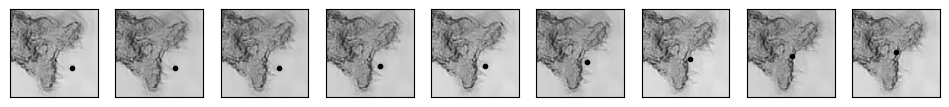

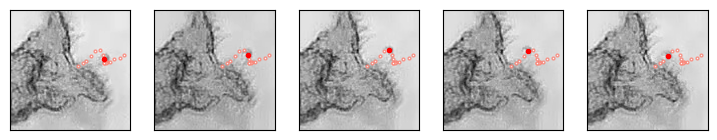

In [5]:
# 1) 140-235 (157: contact, 158: schaufel), 
# 2) 1025-1130 (1045: contact, 1050-1052: schaufeln, cilien)
captures = np.arange(155,164) # 155-164
#captures = [157, 158, 159, 160] # 155-164
cap_imgs = [cv2.imread(os.path.join(frames_filepaths, f"frame_{str(cap).zfill(5)}.jpg"), cv2.IMREAD_GRAYSCALE) for cap in captures]
yx_win = [330, 450, 290, 410]

fig, ax = plt.subplots(1,len(captures),figsize=(12,5))
for nth, img in enumerate(cap_imgs):
    #ax[nth].imshow(img[yx_win[0]:yx_win[1], yx_win[2]:yx_win[3]], cmap="gray")#, extent=[0, img_width / mpp, 0, img_height / mpp])
    ax[nth].imshow(img, cmap="gray")#, extent=[0, img_width / mpp, 0, img_height / mpp])
    ax[nth].set(xticks=(), yticks=(), ylim=(yx_win[0],yx_win[1]), xlim=(yx_win[2], yx_win[3]))
    set_spines_visible(ax=ax[nth])
    x, y = df.loc[df.fns==f"frame_{str(captures[nth]).zfill(5)}", ["x", "y"]].T.values
    ax[nth].plot(x,y, "ok", mfc="k", ms=3)


captures = np.arange(1049, 1054)# [1045,1050,1051,1052] # 1049-1057
#captures = np.arange(1049, 1057)# [1045,1050,1051,1052] # 1049-1057
cap_imgs = [cv2.imread(os.path.join(frames_filepaths, f"frame_{str(cap).zfill(5)}.jpg"), cv2.IMREAD_GRAYSCALE) for cap in captures]
yx_win = [330, 450, 290, 410]
traj = np.concatenate([df.loc[df.fns==f"frame_{str(nth).zfill(5)}", ["x", "y"]].values for nth in np.arange(1040, 1057)])

fig, ax = plt.subplots(1,len(captures),figsize=(9,4))
for nth, img in enumerate(cap_imgs):
    #ax[nth].imshow(img[yx_win[0]:yx_win[1], yx_win[2]:yx_win[3]], cmap="gray")#, extent=[0, img_width / mpp, 0, img_height / mpp])
    ax[nth].imshow(img, cmap="gray")#, extent=[0, img_width / mpp, 0, img_height / mpp])
    ax[nth].plot(traj[:,0], traj[:,1], "o", color="salmon", ms=2, alpha=.8, mfc="w")#, mfc="w"
    ax[nth].set(xticks=(), yticks=(), ylim=(yx_win[0],yx_win[1]), xlim=(yx_win[2], yx_win[3]))
    set_spines_visible(ax=ax[nth])
    x, y = df.loc[df.fns==f"frame_{str(captures[nth]).zfill(5)}", ["x", "y"]].T.values
    ax[nth].plot(x,y, "or", mfc="r", ms=3)
    ax[nth].invert_yaxis()

#fig.savefig(f"{results_save_path}food_particle_captured_120Hz_HD_img-trajectories.jpg", dpi=600, bbox_inches="tight", edgecolor=None) #if SAVE_FIGURES else None

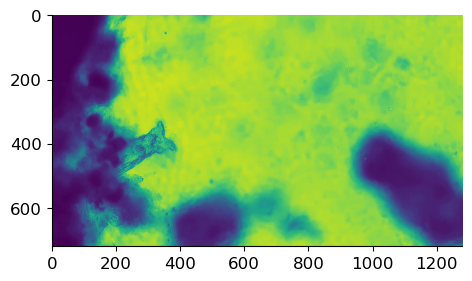

In [11]:
#stacked.astype("int16")- 50
plt.imshow(stacked)

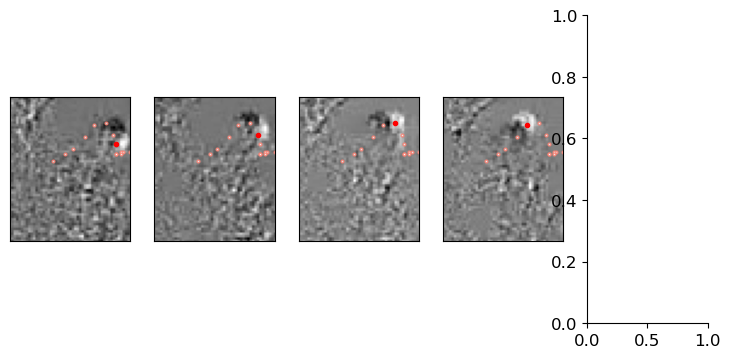

In [17]:
#captures = np.arange(155,164)
captures = np.arange(1049, 1054)# [1045,1050,1051,1052] # 1049-1057
cap_imgs = [cv2.imread(os.path.join(frames_filepaths, f"frame_{str(cap).zfill(5)}.jpg"), cv2.IMREAD_GRAYSCALE) for cap in captures]
stacked = np.stack(cap_imgs)
dstacked = np.diff(stacked.astype("int16"), axis=0)
#stacked = np.sum(stacked, axis=0)
#mean_img = np.mean(stacked, axis=0)
#norm_imgs = [img-mean_img for img in cap_imgs]
yx_win = [330, 450, 290, 410]
yx_win = [360, 420, 340, 390]
traj = np.concatenate([df.loc[df.fns==f"frame_{str(nth).zfill(5)}", ["x", "y"]].values for nth in np.arange(1040, 1057)]) # np.arange(1040, 1057) / np.arange(150,170)

fig, ax = plt.subplots(1,len(captures),figsize=(9,4))
for nth, img in enumerate(dstacked):#for nth, img in enumerate(cap_imgs):
    
    ax[nth].imshow(img, cmap="gray")
    ax[nth].plot(traj[:,0], traj[:,1], "o", color="salmon", ms=2, alpha=.8, mfc="w")#, mfc="w"
    ax[nth].set(xticks=(), yticks=(), ylim=(yx_win[0],yx_win[1]), xlim=(yx_win[2], yx_win[3]))
    set_spines_visible(ax=ax[nth])
    x, y = df.loc[df.fns==f"frame_{str(captures[nth]).zfill(5)}", ["x", "y"]].T.values
    ax[nth].plot(x,y, "or", mfc="r", ms=3)
    ax[nth].invert_yaxis()

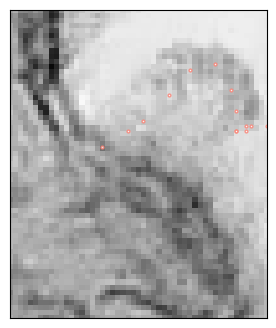

In [18]:
mstacked = np.min(stacked, axis=0)

fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.imshow(mstacked, cmap="gray")
ax.plot(traj[:,0], traj[:,1], "o", color="salmon", ms=2, alpha=.8, mfc="w")#, mfc="w"
ax.set(xticks=(), yticks=(), ylim=(yx_win[0],yx_win[1]), xlim=(yx_win[2], yx_win[3]))
set_spines_visible(ax=ax)
x, y = df.loc[df.fns==f"frame_{str(captures).zfill(5)}", ["x", "y"]].T.values
ax.plot(x,y, "or", mfc="r", ms=3)
ax.invert_yaxis()

(315.15450000000004, 498.3155, 321.06999999999994, 449.77)

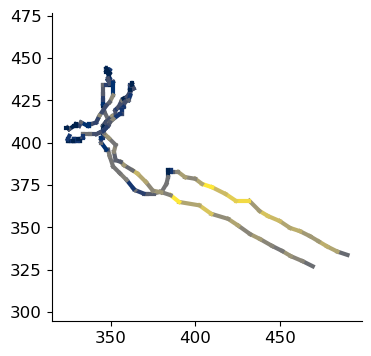

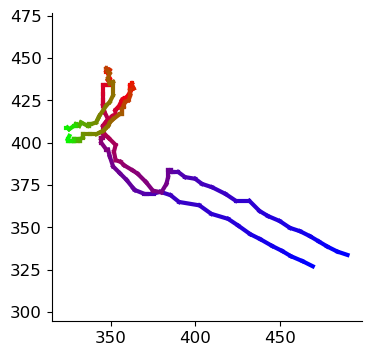

In [5]:
from utils.utils import argnotnan

fig, ax = plt.subplots(figsize=(4,4))
for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v))
    #c_, _ = create_scalarmappable("plasma", argnotnan(v))
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=3)
plt.axis("equal")

fig, ax = plt.subplots(figsize=(4,4))
for prt in prts:
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("brg", range(len(x)-1))
    #c_, _ = create_scalarmappable("plasma", argnotnan(v))
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=3)
plt.axis("equal")

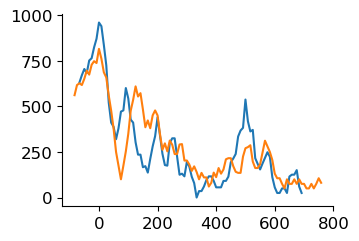

In [85]:

fig, ax = plt.subplots(figsize=(3.5,2.5))
for t, v in normalized_data:
    tmp = pd.DataFrame({"t": t, "v": v / mpp * fps});
    ax.plot(tmp.t, tmp.v.rolling(window=4).mean())

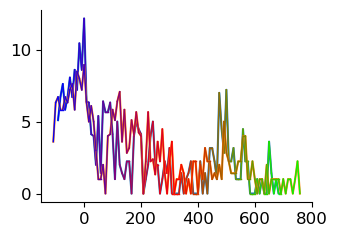

In [77]:
normalized_data = []

for prt in prts:
    v = groups[prt]["v"]
    v_non_nan = v[~np.isnan(v)]#v.dropna().values
    ctime = np.arange(len(v_non_nan))
    idx_max = np.argmax(v_non_nan)
    timeidx = ctime[idx_max]
    
    # Normalize time
    norm_time = (ctime - timeidx) / fps * 1000
    normalized_data.append((norm_time, v_non_nan))

fig, ax = plt.subplots(figsize=(3.5,2.5))
for t, v in normalized_data:
    ax.plot(t, v)
    c_, _ = create_scalarmappable("brg", range(len(t)))
    plot_colorline(t, v, colors=c_, ax=ax, lw=1)

#ax.set(xlim=(-200, 200))
# this can still be smoothed!!!


In [ ]:
# load masks of first images
first_frames = df.reset_index().drop_duplicates(subset='particle', keep='first').index.values
#mask_dir = "./data/seg_masks/2024_0409_183844_105_food_capture_masks/"
mask_fps = [f for f in sorted(os.listdir(mask_dir))]
mask_fp = [os.path.join(mask_dir, mask_fps[ff]) for ff in first_frames]
contour_list = get_contours_from_segmasks(mask_fp)
df_stats = get_contour_stats(contour_list)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
SAVE_FIGURES = False

ax_params = dict(xlim=(-370, 0), ylim=(-125, 200), xticks=[],yticks=[]) #
normalize = True

fig, ax = plt.subplots(figsize=(3,3))
for nth, cnt in enumerate(contour_list):
    cnt = np.squeeze(cnt.copy())
    if normalize:
        cnt[:,0] = cnt[:,0] - df_stats.loc[nth, "centroid_x"]
        cnt[:,1] = cnt[:,1] - df_stats.loc[nth, "centroid_y"]
    ax.fill_between(cnt[:,0], cnt[:,1], facecolor="lightgray")  #, lw=1, edgecolor="gray", linestyle="--")
    ax.plot(cnt[:,0], cnt[:,1], ":", color="gray", alpha=.5, lw=.5)

for nth, prt in enumerate(prts):
    x, y, v = groups[prt]["x"], groups[prt]["y"], groups[prt]["v"]
    c_, _ = create_scalarmappable("cividis", argnotnan(v), global_vminmax)
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        y = y - df_stats.loc[nth, "centroid_y"]
    ax.plot(x[1:], y[1:], "-", lw=3, color="gray", alpha=.5)
    plot_colorline(x[1:], y[1:], colors=c_, ax=ax, lw=2)

ax.set(**ax_params); ax.set_aspect('equal', adjustable='datalim'); 
ax.invert_xaxis()

vvals = df.v.values / mpp * fps
print(np.nanmin(vvals), np.nanmax(vvals))
# colorbar as inset axes
_, sm = create_scalarmappable("cividis", argnotnan(df.v.values), vminmax=global_vminmax)
axin = inset_axes(ax, width="20%", height="3%", loc="lower right", borderpad=.75)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 20, 40])
cbar.set_ticklabels(["0", "1", "2"], fontsize=10)

cbar.set_label("mm s$^{-1}$", fontsize=12)
axin.xaxis.set_ticks_position("top")
axin.xaxis.set_label_position("top")
set_spines_visible(ax=ax)
plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(-100, -110), linewidth=3, fontsize=0)
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_with_mask.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None


In [ ]:
print(global_vminmax)
fig, ax = plt.subplots(figsize=(3.5,2.5))

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    #ax.plot(x / mpp, v, "-", lw=1.5, color=ccols[prt-1], alpha=.8)
    c_, _ = create_scalarmappable("brg", np.arange(0, len(x)))
    plot_colorline(x / mpp, v / mpp * fps / 1000, colors=c_, alpha=.8)

for nth, prt in enumerate(prts):
    x, v = groups[prt]["x"], groups[prt]["v"]
    if normalize:
        x = x - df_stats.loc[nth, "centroid_x"]
        x = x - x[-1]
    ax.plot(x[np.where(v==np.nanmax(v))[0][0]] / mpp, np.nanmax(v) / mpp * fps / 1000, "o", mfc="w", ms=4, color="r")
    ax.plot(x[-1] / mpp, v[-1] / mpp * fps / 1000, "o", mfc="w", ms=4, color="k")
    #ax.plot(x[1] / mpp, v[1], "o", mfc="w", ms=4, color=ccols[prt-1])

_, sm = create_scalarmappable("brg", np.arange(0,51))
axin = inset_axes(ax, width="20%", height="3%", loc="upper left", borderpad=1.05)
cbar = fig.colorbar(sm, cax=axin, orientation="horizontal", ticks=[0, 50])
cbar.set_ticklabels(["first", "last"], fontsize=10)

cbar.set_label("traj.", fontsize=12)
axin.xaxis.set_ticks_position("bottom")
axin.xaxis.set_label_position("bottom")

ax.set(xlabel=("X (µm)"), ylabel=("Velocity (mm s$^{-1}$)"), ylim=(0,2.1), yticks=(0,1,2));
ax.minorticks_on()
fig.savefig(f"{results_save_path}food_particle_captured_trajectories_against_X.jpg", dpi=600, bbox_inches="tight", edgecolor=None) if SAVE_FIGURES else None

In [ ]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None